<a href="https://colab.research.google.com/github/sophiayeung/-Airbnb_Price_ADAMs/blob/main/ADAMS_YeungWingShan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table of Contents

    1. Introduction
    2. Data Import and Cleaning
        2.1 Data import
          2.2.1 Remove column
          2.2.2 Change Datatype
          2.2.3 Cleaning missing data
          2.2.4 Remove non-english rows
    3. Feature Analysis and Engineering
        3.1 Standardization for numerical columns
        3.2 Text Cleaning
    4. Baseline Model for non-textual Data
        4.1 Data Preparation
        4.2 Linear Regression
        4.3 Random Forest
        4.4 XGB Boost
    5. Neural Network for textual data
        5.1 Data Preparation
        5.2 LSTM
        5.3 Bidirectional LSTM
        5.4 CNN With GlobalAveragePoolomg1D
        5.5 CNN With MaxPooling 
    6. Combine Textual and non-textual features
      6.1 Only 10 best features
      6.2 All non-textual features
      6.3 Export the result 
    7. Conclusion



---

# 1. Introduction

The task of the assignment is aimed to predict the accommodation price for Airbnb Listing in London. The data has more than 55000 properties, which containing the listing attributes (e.g., location, number of rooms, property type), texts with the listing description, and rental price per night.

In the following, we analyse the data, apply feature engineering and data cleanin. Afterwards, we would create different models for data prediction and selection and fine-tune the best out of all. Finally, the model is applied to our test data for prediction.


In [ ]:
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import re
import datetime
import string
import time
import xgboost as xgb

import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Input, concatenate, Dense, Embedding, LSTM, GRU, Bidirectional, BatchNormalization, Dropout
from tensorflow.keras import activations, losses, layers
from keras.callbacks import EarlyStopping

import seaborn as sns
import math 

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
from keras.layers.core import Dense, SpatialDropout1D

In [ ]:
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
nltk.download(['stopwords'])

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 2. Data Import and Cleaning

## 2.1 Data Import

In [ ]:
train = pd.read_csv("train.csv", sep=",", encoding="utf-8", engine="python")
test = pd.read_csv("test.csv", sep=",", encoding="utf-8", engine="python")

First we take a look on how data looks like: 

In [ ]:
## get to know the data
print(f"The training dataset is composed of {train.shape[0]} rows and {train.shape[1]} columns.")
print(f"The testing dataset is composed of {test.shape[0]} rows and {test.shape[1]} columns.")

print(train.columns)

The training dataset is composed of 55284 rows and 42 columns.
The testing dataset is composed of 29769 rows and 41 columns.
Index(['name', 'summary', 'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'transit', 'house_rules', 'picture_url',
       'host_id', 'host_since', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'zipcode', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'amenities', 'price', 'guests_included',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'cancellation_policy', 'reviews_per_month',
       'listing_id'],
      dtype='object')


In [ ]:
train.head() 

,name,summary,space,description,experiences_offered,neighborhood_overview,transit,house_rules,picture_url,host_id,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month,listing_id
0,Attic Room in historic Greenwich,The room does not have a door but its own disc...,Double room available in historic royal Greenw...,The room does not have a door but its own disc...,business,NaN,Parking is restricted in London. Visitors park...,no shoes on carpets no food in attic room no o...,https://a0.muscache.com/im/pictures/20045164/7...,2167992,...,95.0,10.0,10.0,10.0,10.0,10.0,10.0,strict_14_with_grace_period,2.37,9Q1RD6H7IO
1,Lovely Garden Studio Private Access,"Garden studio with private entrance, 5 minutes...","Beautiful studio with a king size bed, a sofa ...","Garden studio with private entrance, 5 minutes...",none,Crouch End is a very hip and friendly neighbou...,Walk across the street to the W3 bus stop and ...,We'd love it if you would remove your shoes at...,https://a0.muscache.com/im/pictures/8d1ddcdc-f...,16148175,...,99.0,10.0,10.0,10.0,10.0,10.0,10.0,moderate,2.97,6XDPZPGLSR
2,Comfi apartment 2 close to wimbledon tennis court,NaN,NaN,NaN,none,NaN,NaN,1- No party or event allowed. 2-No smoking ins...,https://a0.muscache.com/im/pictures/e7e4a740-d...,272000199,...,84.0,9.0,9.0,10.0,10.0,9.0,8.0,strict_14_with_grace_period,1.73,SND9OPN6IY
3,Luxury room in the heart of London - SW4,Luxury first floor Victorian split level maiso...,"Your room will be fully furnished, and it will...",Luxury first floor Victorian split level maiso...,none,"Gail coffee shop, just round the corner as wel...",Happy to advise on things to do in London and ...,- Check-in after 18:30pm and no later than 20:...,https://a0.muscache.com/im/pictures/7c2b2fcc-e...,3361233,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,flexible,NaN,SE3B7BXN9G
4,Excellent city Apartment with Private Patio,"NEW luxury apartment, with private outside pat...","A modern, well-equipped, cosy apartment close ...","NEW luxury apartment, with private outside pat...",none,NaN,NaN,"I am very happy for your visit, but please car...",https://a0.muscache.com/im/pictures/ca1494da-f...,94317022,...,100.0,10.0,10.0,10.0,10.0,10.0,10.0,strict_14_with_grace_period,2.32,E0C82VK0VF


## 2.2 Data Cleaning
The data cleaning part includes the below steps:
- Remove column that's not required for the analysis
- Change Datatype
- Cleaning missing data
- Remove non-english rows

### 2.2.1 Remove Column

summary and description columns returns almost the same data but the number of null column is different. After checking the content of the summary, I decided to merge two columns together.

In [ ]:
train.summary = train['summary'].fillna(train['description'])
test.summary = test['summary'].fillna(test['description'])

In [ ]:
# check out missing data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
house_rules,23378,0.422871
transit,19807,0.358277
neighborhood_overview,19506,0.352833
host_response_time,17802,0.322010
host_response_rate,17802,0.322010


In [ ]:
train

,name,summary,space,description,experiences_offered,neighborhood_overview,transit,house_rules,picture_url,host_id,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month,listing_id
0,Attic Room in historic Greenwich,The room does not have a door but its own disc...,Double room available in historic royal Greenw...,The room does not have a door but its own disc...,business,NaN,Parking is restricted in London. Visitors park...,no shoes on carpets no food in attic room no o...,https://a0.muscache.com/im/pictures/20045164/7...,2167992,...,95.0,10.0,10.0,10.0,10.0,10.0,10.0,strict_14_with_grace_period,2.37,9Q1RD6H7IO
1,Lovely Garden Studio Private Access,"Garden studio with private entrance, 5 minutes...","Beautiful studio with a king size bed, a sofa ...","Garden studio with private entrance, 5 minutes...",none,Crouch End is a very hip and friendly neighbou...,Walk across the street to the W3 bus stop and ...,We'd love it if you would remove your shoes at...,https://a0.muscache.com/im/pictures/8d1ddcdc-f...,16148175,...,99.0,10.0,10.0,10.0,10.0,10.0,10.0,moderate,2.97,6XDPZPGLSR
2,Comfi apartment 2 close to wimbledon tennis court,NaN,NaN,NaN,none,NaN,NaN,1- No party or event allowed. 2-No smoking ins...,https://a0.muscache.com/im/pictures/e7e4a740-d...,272000199,...,84.0,9.0,9.0,10.0,10.0,9.0,8.0,strict_14_with_grace_period,1.73,SND9OPN6IY
3,Luxury room in the heart of London - SW4,Luxury first floor Victorian split level maiso...,"Your room will be fully furnished, and it will...",Luxury first floor Victorian split level maiso...,none,"Gail coffee shop, just round the corner as wel...",Happy to advise on things to do in London and ...,- Check-in after 18:30pm and no later than 20:...,https://a0.muscache.com/im/pictures/7c2b2fcc-e...,3361233,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,flexible,NaN,SE3B7BXN9G
4,Excellent city Apartment with Private Patio,"NEW luxury apartment, with private outside pat...","A modern, well-equipped, cosy apartment close ...","NEW luxury apartment, with private outside pat...",none,NaN,NaN,"I am very happy for your visit, but please car...",https://a0.muscache.com/im/pictures/ca1494da-f...,94317022,...,100.0,10.0,10.0,10.0,10.0,10.0,10.0,strict_14_with_grace_period,2.32,E0C82VK0VF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55279,"Brixton/Camberwell DBL bedroom, brand new flat",Large private double bedroom available in a br...,NaN,Large private double bedroom available in a br...,none,Situated smack bang in the centre of south Lon...,Loughbrough Junction Station (Thameslink Line)...,Take shoes off at the door No food or drink on...,https://a0.muscache.com/im/pictures/f79f4455-2...,28354624,...,100.0,10.0,10.0,10.0,10.0,9.0,10.0,strict_14_with_grace_period,0.20,HSY40NEHOI
55280,End suite with private bathroom. Close to the ...,Private end suite with smart TV and PlayStatio...,Private end suite with smart TV and PlayStatio...,Private end suite with smart TV and PlayStatio...,none,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/f7f0103a-e...,207619004,...,100.0,10.0,10.0,10.0,10.0,10.0,10.0,flexible,0.08,XZXB1NS63Y
55281,The place full of a good energy!,3 double bedroom APARTMENT for families and fr...,"Warm, clean and safe, close to city atractions...",3 double bedroom APARTMENT for families and fr...,none,"Location, location, location: Local amenities:...","Direct, convenient and quick 20 mins access to...",- SMOKING is STRICTLY FORBIDDEN at the buildin...,https://a0.muscache.com/im/pictures/11207118-1...,137970479,...,96.0,10.0,10.0,10.0,10.0,10.0,10.0,flexible,1.60,Z2T8G6D82D
55282,Amazing 1BD apartment right next to Finsbury Park,This amazing 1 bed apartment offers an ideal b...,Welcome to this modern and bright apartment in...,This amazing 1 bed apartment offers an ideal b...,none,NaN,Finsbury Park underground station: 5

After some inspect on the data I removed some columns that wouldn't be required in the analysis (e.g. host_id, house_rules, transit, description, etc).

In [ ]:
columns_to_keep = [
    'listing_id',
    'name', 
    'summary', 
    'experiences_offered',
    'host_response_time', 
    'host_response_rate',
    'host_is_superhost', 
    'host_has_profile_pic', 
    'host_identity_verified', 
    'neighbourhood_cleansed',
    'property_type', 
    'room_type', 
    'accommodates',
    'bathrooms', 
    'bedrooms',
    'beds', 
    'bed_type', 
    'price', 
    'amenities',
    'guests_included',
    'review_scores_rating', 
    'review_scores_accuracy',
    'review_scores_cleanliness', 
    'review_scores_checkin',
    'review_scores_communication', 
    'review_scores_location',
    'review_scores_value', 
    'cancellation_policy', 
    'reviews_per_month']

# train set keep only listed columns
df_train = train.loc[:,columns_to_keep]

# test set keep the same listed columns, but without price
columns_to_keep_test = columns_to_keep.remove('price')
df_test = test.loc[:,columns_to_keep]

### 2.2.2 Change datatype

In [ ]:
df_train.dtypes

listing_id                      object
name                            object
summary                         object
experiences_offered             object
host_response_time              object
host_response_rate              object
host_is_superhost               object
host_has_profile_pic            object
host_identity_verified          object
neighbourhood_cleansed          object
property_type                   object
room_type                       object
accommodates                     int64
bathrooms                      float64
bedrooms                       float64
beds                           float64
bed_type                        object
price                          float64
amenities                       object
zipcode                         object
guests_included                  int64
review_scores_rating           float64
review_scores_accuracy         float64
review_scores_cleanliness      float64
review_scores_checkin          float64
review_scores_communicati

`host_response_rate` is obviously float type but there's "%" at the end and we cannot directly convert it into float, so we need to drop it before changing the datatype.

In [ ]:
# drop the % sign from the host_response_rate
df_train["host_response_rate"] = df_train["host_response_rate"].astype(str)
df_train["host_response_rate"] = df_train["host_response_rate"].str.strip("%\n ")

# do the same for test data
df_test["host_response_rate"] = df_test["host_response_rate"].astype(str)
df_test["host_response_rate"] = df_test["host_response_rate"].str.strip("%\n ")

In [ ]:
# change amenities to text
test = ",".join(df_train["amenities"])

In [ ]:
numerical_columns = ['bathrooms', 'bedrooms', 'beds', 'reviews_per_month','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value']
categorical_columns = ['host_response_time','experiences_offered', 'property_type','room_type', 'bed_type']
text_columns = ['name','summary','neighbourhood_cleansed', 'amenities']
boolean_columns = ['host_is_superhost','host_has_profile_pic','host_identity_verified']

In [ ]:
# changing the datatype to the correct one

for col in categorical_columns:
    df_train[col] = df_train[col].astype('category')
    df_test[col] = df_test[col].astype('category')
    
for col in text_columns:
    df_train[col] = df_train[col].astype('string')    
    df_test[col] = df_test[col].astype('string')    
    
for col in boolean_columns:
    df_train[col] = df_train[col].astype(bool)
    df_test[col] = df_test[col].astype(bool)


In [ ]:
# check again the datatype
df_train.dtypes

listing_id                       object
name                             string
summary                          string
experiences_offered            category
host_response_time             category
host_response_rate               object
host_is_superhost                  bool
host_has_profile_pic               bool
host_identity_verified             bool
neighbourhood_cleansed           string
property_type                  category
room_type                      category
accommodates                      int64
bathrooms                       float64
bedrooms                        float64
beds                            float64
bed_type                       category
price                           float64
amenities                        string
zipcode                        category
guests_included                   int64
review_scores_rating            float64
review_scores_accuracy          float64
review_scores_cleanliness       float64
review_scores_checkin           float64


In [ ]:
# check again the datatype
df_test.dtypes

listing_id                       object
name                             string
summary                          string
experiences_offered            category
host_response_time             category
host_response_rate               object
host_is_superhost                  bool
host_has_profile_pic               bool
host_identity_verified             bool
neighbourhood_cleansed           string
property_type                  category
room_type                      category
accommodates                      int64
bathrooms                       float64
bedrooms                        float64
beds                            float64
bed_type                       category
amenities                        string
zipcode                        category
guests_included                   int64
review_scores_rating            float64
review_scores_accuracy          float64
review_scores_cleanliness       float64
review_scores_checkin           float64
review_scores_communication     float64


We want to check the correlation between the numerical data and maybe remove some highly correlated columns as they are providing similar information. However, after checking the correlation, I decided not to remove any as there's no features that has correlation > 0.8 and it will lead to information loss if I remove them.

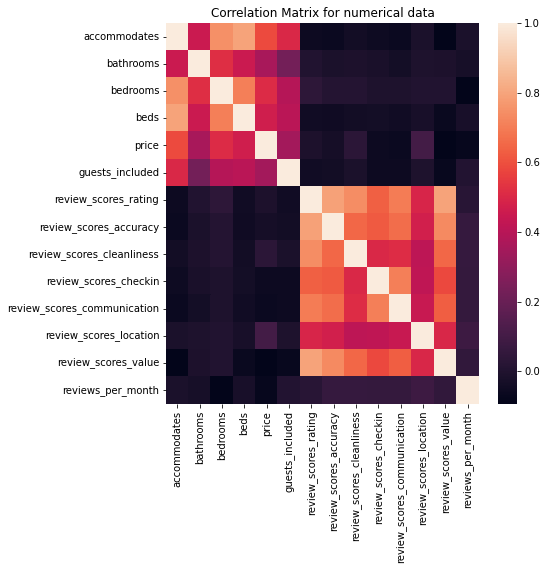

In [ ]:
#quick heatmap check for correlation
df_numerical = df_train.select_dtypes(include=['int','float'])

plt.figure(figsize=(7,7))
sns.heatmap(df_numerical.corr())
plt.title('Correlation Matrix for numerical data')

plt.show()

In [ ]:
#count unique values for each column
for col in df_train:
    print(col, df_train[col].nunique())

listing_id 55284
name 54042
summary 49111
experiences_offered 5
host_response_time 4
host_response_rate 70
host_is_superhost 1
host_has_profile_pic 1
host_identity_verified 1
neighbourhood_cleansed 33
property_type 38
room_type 4
accommodates 16
bathrooms 20
bedrooms 12
beds 21
bed_type 5
price 476
amenities 50376
zipcode 26556
guests_included 16
review_scores_rating 57
review_scores_accuracy 9
review_scores_cleanliness 9
review_scores_checkin 9
review_scores_communication 9
review_scores_location 9
review_scores_value 9
cancellation_policy 8
reviews_per_month 862


### 2.2.3 Cleaning Missing Data

In [ ]:
print(df_train.isnull().sum())

listing_id                         0
name                              14
summary                         2954
experiences_offered                0
host_response_time             17802
host_response_rate                 0
host_is_superhost                  0
host_has_profile_pic               0
host_identity_verified             0
neighbourhood_cleansed             0
property_type                      0
room_type                          0
accommodates                       0
bathrooms                         70
bedrooms                          62
beds                             262
bed_type                           0
price                              0
amenities                          0
zipcode                         1272
guests_included                    0
review_scores_rating           13415
review_scores_accuracy         13448
review_scores_cleanliness      13442
review_scores_checkin          13483
review_scores_communication    13446
review_scores_location         13480
r

First let's remove the null value from the summary. We would replace it with empty space as after text preprocessing the columns will not contains any additional columns that cause noise.

In [ ]:
# replace NaN values from summary using empty space
df_train.summary = df_train.summary.fillna(" ")
df_test.summary = df_test.summary.fillna(" ")

In [ ]:
# replace NaN values from name using empty space
df_train.name = df_train.name.fillna(" ")
df_test.name = df_test.name.fillna(" ")

For numerical data, we first want to check the distribution of the data. If it's skewed, it would not be a good option to replace the misisng value with mean, as there will be extrem data that cause bias when using mean.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


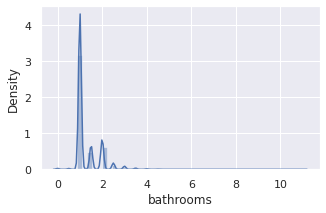

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


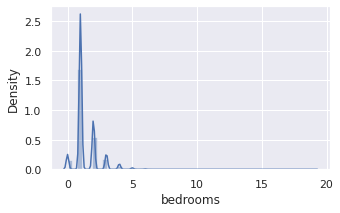

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


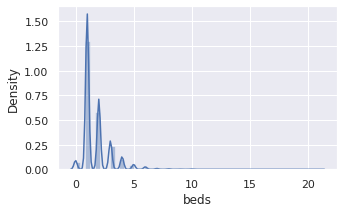

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


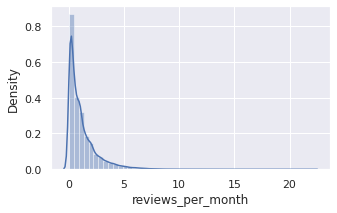

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


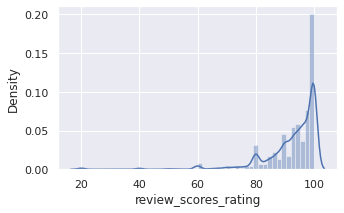

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


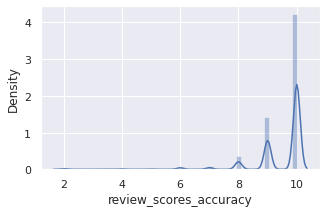

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


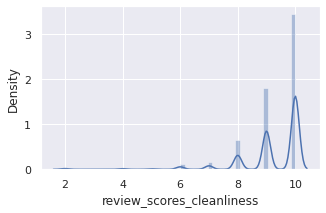

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


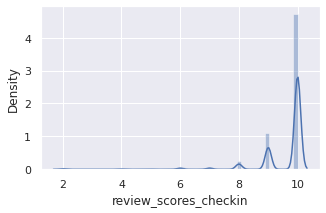

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


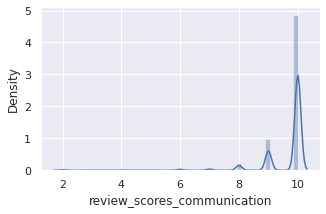

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


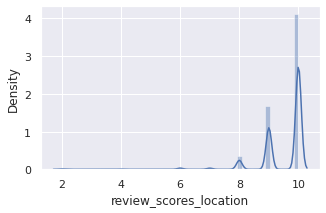

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


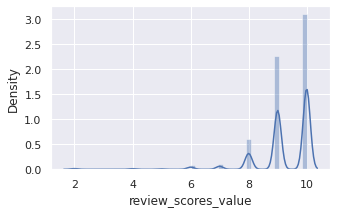

In [ ]:
for col in numerical_columns:
  sns.set(rc={'figure.figsize':(5,3)})
  sns.distplot(df_train[col])
  plt.show()

From the graph, we can tell that the distrubtion of all data are skewed. Therefore, we will use mode to replace missing data. 

In [ ]:
# using mean to replace the null for all numerical column
for col in numerical_columns:
     df_train[col].fillna(df_train[col].mode()[0], inplace=True)
     df_test[col].fillna(df_test[col].mode()[0], inplace=True)

From categorical columns, we simply just add a category "Missing" and assign all null value to the category.

In [ ]:
print(df_train[categorical_columns].isnull().sum())

host_response_time     17802
experiences_offered        0
property_type              0
room_type                  0
bed_type                   0
zipcode                 1272
dtype: int64


In [ ]:
# replace null value with "Missing" cateorgy for host response time
df_train['host_response_time'] = df_train['host_response_time'].cat.add_categories('Missing')
df_train['host_response_time'] = df_train['host_response_time'].fillna("Missing")

df_test['host_response_time'] = df_test['host_response_time'].cat.add_categories('Missing')
df_test['host_response_time'] = df_test['host_response_time'].fillna("Missing")


In [ ]:
print(df_train['host_response_time'].value_counts())

within an hour        23982
Missing               17802
within a few hours     7105
within a day           5274
a few days or more     1121
Name: host_response_time, dtype: int64


For boolean type, all the NA values will be treated as false, so we don't need to update it. https://pandas.pydata.org/pandas-docs/stable/user_guide/boolean.html

In [ ]:
df_train.isnull().sum()

listing_id                     0
name                           0
summary                        0
experiences_offered            0
host_response_time             0
host_response_rate             0
host_is_superhost              0
host_has_profile_pic           0
host_identity_verified         0
neighbourhood_cleansed         0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                      0
bedrooms                       0
beds                           0
bed_type                       0
price                          0
amenities                      0
guests_included                0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
cancellation_policy            0
reviews_per_month              0
dtype: int64

In [ ]:
df_test.isnull().sum()

listing_id                     0
name                           0
summary                        0
experiences_offered            0
host_response_time             0
host_response_rate             0
host_is_superhost              0
host_has_profile_pic           0
host_identity_verified         0
neighbourhood_cleansed         0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                      0
bedrooms                       0
beds                           0
bed_type                       0
amenities                      0
guests_included                0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
cancellation_policy            0
reviews_per_month              0
dtype: int64

### 2.2.4 Remove non-english rows
There are some non-english rows in the summary and names, and we do not want them to create noisy while training our model. Therefore, I imported a library called "langdetect" to detect their langauge, and replace those who's not english columns to empty space. 

In [ ]:
!pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 981 kB 5.4 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=77a62d6b78aadc175eeb775915d9365c81bfef1f0174c41b33e82e588b5ba108
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [ ]:
from langdetect import detect
def detect_my(text):
   try:
       return detect(text)
   except:
       return 'unknown'
       
start_time = time.perf_counter()
df_train['name_language'] = df_train['name'].apply(detect_my)
df_train['summary_language'] = df_train['summary'].apply(detect_my)
df_test['summary_language'] = df_test['summary'].apply(detect_my)
df_test['name_language'] = df_test['name'].apply(detect_my)
end_time = time.perf_counter()
total_time = end_time - start_time
print(f'Training Took {total_time:.4f} seconds')

Training Took 1452.4664 seconds


In [ ]:
# check the number of non-english name and summary in train set
train_name_noeng = sum(df_train['name_language']!='en')
train_summary_noeng = sum(df_train['summary_language']!='en')
print(f'number of non-english name in train set: {train_name_noeng}')
print(f'number of non-english summary in train set: {train_summary_noeng}')

test_name_noeng = sum(df_test['name_language']!='en')
test_summary_noeng = sum(df_test['summary_language']!='en')
print(f'number of non-english name in test set: {test_name_noeng}')
print(f'number of non-english summary in test set: {test_summary_noeng}')

number of non-english name in train set: 8181
number of non-english summary in train set: 3426
number of non-english name in test set: 4346
number of non-english summary in test set: 1832


In [ ]:
# create a copy to avoid overwriting the orignial data
df_drop_train = df_train.copy()
df_drop_test = df_test.copy()


# change all non-english rows for train data to empty space
df_drop_train['name'].mask(df_drop_train['name_language'] != 'en', " " , inplace=True )
df_drop_train['summary'].mask(df_drop_train['summary_language'] != 'en', " " , inplace=True )

# change all non-english rows for test data to empty space
df_drop_test['name'].mask(df_drop_test['name_language'] != 'en', " " , inplace=True )
df_drop_test['summary'].mask(df_drop_test['summary_language'] != 'en', " " , inplace=True )

In [ ]:
# check whether those which detected as english is now empty
df_drop_test['name'].loc[df_drop_test['name_language'] != 'en', ].head(5)

2      
12     
14     
20     
21     
Name: name, dtype: string

In [ ]:
# remove the created columns
df_drop_train = df_drop_train.drop(['name_language','summary_language'],axis=1)
df_drop_test = df_drop_test.drop(['name_language','summary_language'],axis=1)

## 2.3. Save and Loan cleaned data

In [ ]:
# create copy to avoid alter the cleaned data
df_clean_train = df_drop_train.copy()
df_clean_test = df_drop_test.copy()

In [ ]:
##save cleaned data for train
open_file = open('data_clean_train.pkl', "wb")
pickle.dump(df_clean_train, open_file)
open_file.close()

In [ ]:
##save cleaned data for test
open_file = open('data_clean_test.pkl', "wb")
pickle.dump(df_clean_test, open_file)
open_file.close()

In [ ]:
## load cleaned data for trian
open_file = open('data_clean_train.pkl', "rb")
df_clean_train = pickle.load(open_file)
open_file.close()

In [ ]:
## load cleaned data for test
open_file = open('data_clean_test.pkl', "rb")
df_clean_test = pickle.load(open_file)
open_file.close()

# 3. Feature Engineering and Textual Preprocessing

In this section, we would like to apply 
- standardization for numerical columns, and </br>
- text cleaning for future NLP.

## 3.1 Standardized for numerical columns
Without standardization of numerical columns, features will contribute differently because of the different scaler. Therefore, we used MinMax scaler to normalize the range of independent variables to 0 to 1, so that the model will perform better.

In [ ]:
df_clean_test[numerical_columns].describe(include='all')

,bathrooms,bedrooms,beds,reviews_per_month,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
count,29769.000000,29769.000000,29769.000000,29769.000000,29769.000000,29769.000000,29769.000000,29769.000000,29769.000000,29769.000000,29769.000000
mean,0.107403,0.115716,0.063508,0.073719,0.929205,0.953483,0.930599,0.964489,0.967365,0.956272,0.929927
std,0.046921,0.072099,0.044916,0.079502,0.117878,0.110303,0.128380,0.099508,0.097182,0.093139,0.119397
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.083333,0.083333,0.037037,0.021011,0.900000,1.000000,0.875000,1.000000,1.000000,0.875000,0.875000
50%,0.083333,0.083333,0.037037,0.065003,0.975000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,0.125000,0.166667,0.074074,0.080105,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df_clean_train[numerical_columns].describe(include='all')

,bathrooms,bedrooms,beds,reviews_per_month,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
count,55284.000000,55284.000000,55284.000000,55284.000000,55284.000000,55284.000000,55284.000000,55284.000000,55284.000000,55284.000000,55284.000000
mean,0.116681,0.072287,0.081300,0.050732,0.929312,0.952975,0.930131,0.964278,0.967160,0.956674,0.930323
std,0.051481,0.045214,0.058208,0.054226,0.116220,0.110109,0.129992,0.099366,0.096825,0.091460,0.119087
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.090909,0.052632,0.047619,0.015433,0.900000,1.000000,0.875000,1.000000,1.000000,0.875000,0.875000
50%,0.090909,0.052632,0.047619,0.044939,0.975000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,0.136364,0.105263,0.095238,0.055379,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We also see a lot of outlier in the data, for example the maximum number of bathrooms is 11 even though the mean is only 1.28. However, it is the natural variations for the airbnb rooms, such that some rooms have more bathrooms. As a result, I decided not to remove the outlier and only do the min max scaler.

In [ ]:
# initialize the scaler
scaler = MinMaxScaler()

# Apply the transormation
for col in numerical_columns:
  df_clean_train[col] = scaler.fit_transform(df_clean_train[[col]]) 
  df_clean_test[col] = scaler.fit_transform(df_clean_test[[col]]) 

In [ ]:
df_clean_train[numerical_columns].describe(include='all')

,bathrooms,bedrooms,beds,reviews_per_month,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
count,55284.000000,55284.000000,55284.000000,55284.000000,55284.000000,55284.000000,55284.000000,55284.000000,55284.000000,55284.000000,55284.000000
mean,0.116681,0.072287,0.081300,0.050732,0.929312,0.952975,0.930131,0.964278,0.967160,0.956674,0.930323
std,0.051481,0.045214,0.058208,0.054226,0.116220,0.110109,0.129992,0.099366,0.096825,0.091460,0.119087
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.090909,0.052632,0.047619,0.015433,0.900000,1.000000,0.875000,1.000000,1.000000,0.875000,0.875000
50%,0.090909,0.052632,0.047619,0.044939,0.975000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,0.136364,0.105263,0.095238,0.055379,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


With the scaler, we can now see that all the max value are 1 and min are 0.

## 3.2 Text Cleaning

The text cleaning progress includes the following steps:
- convert to lowercase
- remove punctuation and HTML tags 
- remove stop words
- remove numbers
- remove double space
- lemmatization 

In [ ]:
!python -m spacy download en_core_web_lg

2022-08-20 09:00:33.689169: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 9.4 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
from nltk.corpus import stopwords
import spacy

nlp = spacy.load("en_core_web_lg")
stop_words = set(stopwords.words('english')) 

In [ ]:
# text cleaning function
def preprocess(text_data):
    stop = stopwords.words('english') # import stop words
    lower_text = text_data.lower()# convert to lowercase
    remove_puncation = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", lower_text) # remove puncation and HTML
    remove_stop = ' '.join([word for word in remove_puncation.split() if word not in stop]) # remove stop words
    remove_number = ' '.join([re.sub(r'\w*\d\w*', '', w) for w in remove_stop.split()] )  # remove numbers
    remove_double = " ".join(remove_number.split())  # remove double space
    lemma = ' '.join([token.lemma_ for token in nlp(remove_double) if (not nlp.vocab[token.lemma_].is_stop) and (len(token.lemma_) > 2)]) #lemmatization
    return lemma

Before preprocessing, we need to replace the bracket and comma by space in amenities columns. It is because in the preprocessing steps works are split by space, so if we don't remove them before the function, it will become one single word, and this is not something we want.

In [ ]:
df_nlp_train = df_clean_train.copy()
df_nlp_test = df_clean_test.copy()

In [ ]:
df_nlp_train['amenities'] = re.sub("[{},]", " ", str(df_nlp_train['amenities']))
df_nlp_test['amenities'] = re.sub("[{},]", " ", str(df_nlp_test['amenities']))

In [ ]:
# apply preprocess for train data
start_time = time.perf_counter()
df_nlp_train['summary_clean'] = df_nlp_train['summary'].apply(preprocess)
df_nlp_train['name_clean'] = df_nlp_train['name'].apply(preprocess)
df_nlp_train['amenities_clean'] = df_nlp_train['amenities'].apply(preprocess)
df_nlp_train.drop(columns=['summary','name']) # remove the non-cleaned columns
end_time = time.perf_counter()
total_time = end_time - start_time
print(f'Training Set took {total_time:.4f} seconds')

Training Set took 1686.6673 seconds


In [ ]:
# apply preprocess for test data
start_time = time.perf_counter()
df_nlp_test['summary_clean'] = df_nlp_test['summary'].apply(preprocess)
df_nlp_test['name_clean'] = df_nlp_test['name'].apply(preprocess)
df_nlp_test['amenities_clean'] = df_nlp_test['amenities'].apply(preprocess)
end_time = time.perf_counter()
total_time = end_time - start_time
print(f'Test Set took {total_time:.4f} seconds')

Test Set took 920.5111 seconds


In [ ]:
# remove the original text columns 
df_nlp_test.drop(columns=['summary','name','amenities'] , inplace=True)
df_nlp_train.drop(columns=['summary','name','amenities'], inplace=True)

## 3.3 Save and load cleaned data

In [ ]:
##save cleaned data for train
open_file = open('data_nlp_train.pkl', "wb")
pickle.dump(df_nlp_train, open_file)
open_file.close()

In [ ]:
##save cleaned data for test
open_file = open('data_nlp_test.pkl', "wb")
pickle.dump(df_nlp_test, open_file)
open_file.close()

In [ ]:
## load cleaned data for trian
open_file = open('data_nlp_train.pkl', "rb")
df_nlp_train = pickle.load(open_file)
open_file.close()

In [ ]:
## load cleaned data for test
open_file = open('data_nlp_test.pkl', "rb") 
df_nlp_test = pickle.load(open_file)
open_file.close()

# 4. Baseline Model for non-textual data

We would like to apply some baseline models for all the non-textual data, in order to see how predictive the data itself without the text data.

## 4.1 Data Preparation

In [ ]:
df_notext_train = df_nlp_train.copy()
df_notext_test = df_nlp_test.copy()

In [ ]:
# Seperate target and non-target variables

# train set
y_train_nosplt = df_notext_train.price # set target as price
non_text_col_train = df_notext_train.select_dtypes(include=['category','int','float']) # select non textual columns
x_train_nodummy =  df_notext_train[non_text_col_train.columns]
x_train_nodummy = x_train_nodummy.drop(columns=['price'])

#test set
non_text_col_test = df_notext_test.select_dtypes(include=['category','int','float']) # select non textual columns
x_test_nodummy =  df_notext_test[non_text_col_test.columns]


With get_dummies function for both test and train data, it returns different number of columns (65 for training and 61 for testing). This is because the test set has less category in the categorical variables. To maintain the same amount of columns, we would apply the train set's columns to test set, but filled it with 0.

In [ ]:
# get dummies for catergory columns
x_train_nosplt = pd.get_dummies(x_train_nodummy, columns=['host_response_time','property_type', 'room_type', 'bed_type','experiences_offered'],drop_first=True)
x_test_nosplt = x_test_nodummy.reindex(columns = x_train_nosplt.columns, fill_value=0)


In [ ]:
# train validation split
X_train, X_val, y_train, y_val = train_test_split(x_train_nosplt, y_train_nosplt, test_size=0.2, random_state=50)

## 4.2 Linear Regression

In [ ]:
#define model
linear = LinearRegression()

#preprocessinf of training data, fit model
linear.fit(X_train, y_train)

#preprocessing of validation data, get predictions
linear_prediction = linear.predict(X_val)

In [ ]:
#evaluate the model
mse = mean_squared_error(y_val, linear_prediction)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_val, linear_prediction)
print('R2 Score',r2)

MSE: 3642.05086769851
RMSE: 60.34940652316732
R2 Score 0.4716138167271141


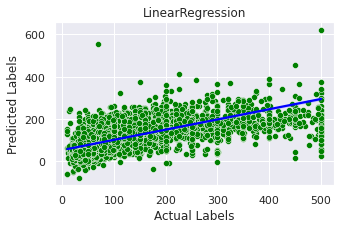

In [ ]:
lin_data = pd.DataFrame({'Predicted Labels':linear_prediction, 'Actual Labels':y_val})

ax = sns.scatterplot(data=lin_data, x="Actual Labels", y="Predicted Labels", color='green')
#add a regression line
sns.regplot(data=lin_data, x="Actual Labels", y="Predicted Labels", scatter=False, ax=ax, color='blue')
plt.title('LinearRegression')
plt.show()

In [ ]:
from sklearn.linear_model import Ridge

# Train model with default alpha=1
ridge = Ridge(alpha=1).fit(X_train, y_train)

#preprocessing of validation data, get predictions
ridge_prediction = linear.predict(X_val)

In [ ]:
#evaluate the model
mse = mean_squared_error(y_val, ridge_prediction)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_val, ridge_prediction)
print('R2 Score',r2)

MSE: 3642.05086769851
RMSE: 60.34940652316732
R2 Score 0.4716138167271141


In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# find optimal alpha with grid search
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(alpha=alpha)
grid = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Score:  0.47863785716892543
Best Params:  {'alpha': 1}


In [ ]:
from sklearn.model_selection import cross_validate

# Cross Validation 10 folds multi-scoring
linear_cv = cross_validate(linear,X_train, y_train, scoring=['neg_mean_squared_error','r2'], cv=10, n_jobs=-1)
mse_val_lr = -linear_cv['test_neg_mean_squared_error'].mean()
rmse_val_lr = np.sqrt(mse_val_lr)
r2_val_lr = linear_cv['test_r2'].mean()

print(f'MSE Validation Set: {mse_val_lr}')
print(f'MSE Validation Set: {rmse_val_lr}')
print(f'R2 Score Validation Set: {r2_val_lr}')

MSE Validation Set: 3671.3555449675914
MSE Validation Set: 60.591711850446934
R2 Score Validation Set: 0.47866265768754435


## 4.3 Random Forest

In [ ]:
rf = RandomForestRegressor(n_estimators=1000, max_depth = None, max_samples = 0.1, random_state=111, verbose=0, n_jobs=10)
rf.fit(X_train, y_train)

rf_prediction = rf.predict(X_val)

In [ ]:
#evaluate the model
mse = mean_squared_error(y_val, rf_prediction)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_val, rf_prediction)
print('R2 Score',r2)

MSE: 3224.623374393279
RMSE: 56.78576735761593
R2 Score 0.5321739044339884


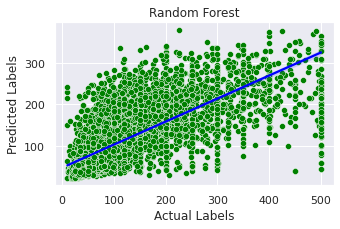

In [ ]:
rf_data = pd.DataFrame({'Predicted Labels':rf_prediction, 'Actual Labels':y_val})

ax = sns.scatterplot(data=rf_data, x="Actual Labels", y="Predicted Labels", color='green')
#add a regression line
sns.regplot(data=rf_data, x="Actual Labels", y="Predicted Labels", scatter=False, ax=ax, color='blue')
plt.title('Random Forest')
plt.show()

In [ ]:
param_grid = { 
            "n_estimators"      : [100, 500,1000],
            "max_features"      : ["auto", "sqrt", "log2"]
             }

In [ ]:
# the processing time for gridsearch is too long, so we use Halving Grid that has better performance
start_time = time.time()

CV_rf = HalvingGridSearchCV(estimator=rf, param_grid=param_grid, cv = 2)
CV_rf.fit(X_train, y_train)

elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time:.4f} ")

Elapsed time: 167.4230 


In [ ]:
CV_rf.best_params_

{'max_features': 'auto', 'n_estimators': 1000}

In [ ]:
# update the random forest regressor with best parameter
rf = RandomForestRegressor(n_estimators=1000, max_features= 'auto', max_depth = None, max_samples = 0.1, random_state=111, verbose=0, n_jobs=10)
rf.fit(X_train, y_train)
rf_prediction = rf.predict(X_val)

#evaluate the model
mse = mean_squared_error(y_val, rf_prediction)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_val, rf_prediction)
print('R2 Score',r2)

MSE: 3224.623374393279
RMSE: 56.78576735761593
R2 Score 0.5321739044339884


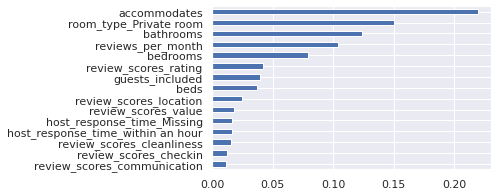

In [ ]:
(pd.Series(rf.feature_importances_, index=X_val.columns)
   .nlargest(15)
   .plot(kind='barh')).invert_yaxis()

Define the most importance 10 features from the random forest.

In [ ]:
important_feature = (pd.Series(rf.feature_importances_, index=X_val.columns).nlargest(10)).index

## 4.4 XGB Boost

In [ ]:
import xgboost as xgb

# Fitting the model
xgb_reg = xgb.XGBRegressor(learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, random_state=111, objective ='reg:squarederror')
xgb_reg.fit(X_train, y_train)
xgb_predictions = xgb_reg.predict(X_val)


In [ ]:
#evaluate the model
mse = mean_squared_error(y_val, xgb_predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_val, xgb_predictions)
print('R2 Score',r2)

MSE: 3307.027167324249
RMSE: 57.50675757964667
R2 Score 0.5202188200006073


In [ ]:
params = {'learning_rate' : [0.1, 1],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'max_depth':[3,5,8]
        }

In [ ]:
start_time = time.time()

CV_xgb = HalvingGridSearchCV(estimator=xgb_reg, param_grid=params, cv = 3)
CV_xgb.fit(X_train, y_train)

elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time:.4f} ")

Elapsed time: 156.4023 


In [ ]:
CV_xgb.best_params_

{'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5}

In [ ]:
# Fitting the model with new parameter
xgb_reg = xgb.XGBRegressor(learning_rate=0.1, gamma = 1, max_depth=5, min_child_weight=1, n_estimators=100, random_state=111, objective ='reg:squarederror')
xgb_reg.fit(X_train, y_train)
xgb_predictions = xgb_reg.predict(X_val)

#evaluate the model
mse = mean_squared_error(y_val, xgb_predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_val, xgb_predictions)
print('R2 Score',r2)

MSE: 3205.8391618194537
RMSE: 56.62013035855228
R2 Score 0.534899104808233


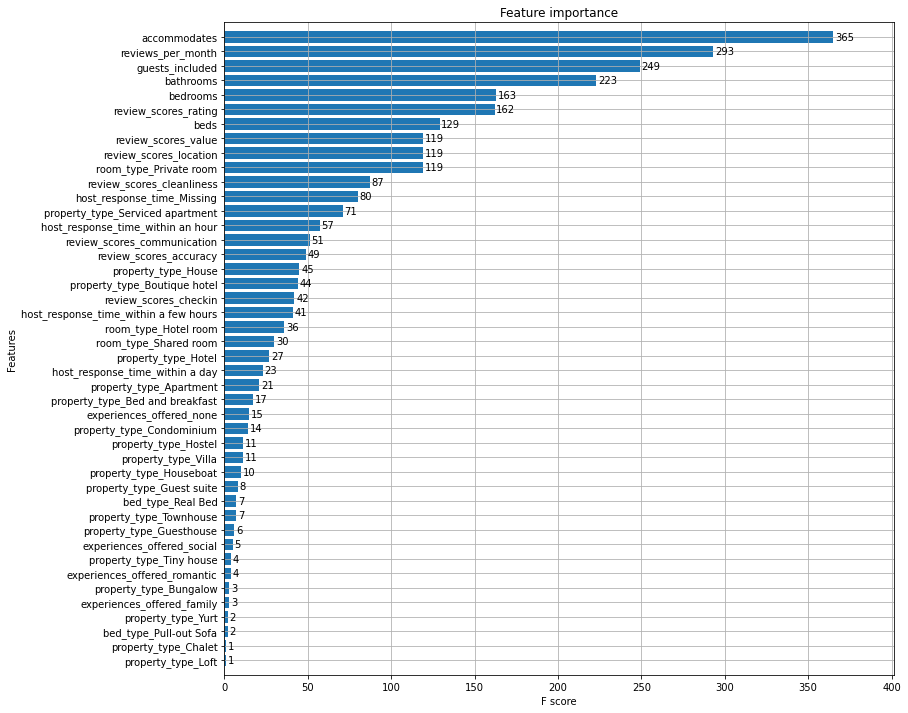

In [ ]:
### Plot the important variables ###
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(xgb_reg, max_num_features=50, height=0.8, ax=ax)
plt.show()

From all the baseline model for non-textual data, we can conclude that the non-textual features can actually do a good job on predicting the price. Among all, random forest performs the best but the differences with the other models is not that significant. </br>
For the feature importance, we could conclude an align result from Random forest and XBG boost, in which accommodates, bedrooms, room_type_private_room, reviews_per_month and bedrooms are the most importance features among all. 

# 5. Neural Network for textual data

## 5.1 Data Preparation

In [ ]:
# Seperate target and non-target variables

# train set
df_cleaned_train = df_nlp_train.copy()
y_train_nlp = df_cleaned_train['price']
x_train_summary = df_cleaned_train['summary_clean']
x_train_name = df_cleaned_train['name_clean']
x_train_amenities = df_cleaned_train['amenities_clean']


# test set
df_cleaned_test = df_nlp_test.copy()
x_test_summary = df_cleaned_test['summary_clean']
x_test_name = df_cleaned_test['name_clean']
x_test_amenities = df_cleaned_test['amenities_clean']


In [ ]:
y_train = tf.convert_to_tensor(y_train_nlp)

For the sequence length, if we used the maximum length and then pad the sequence, it would be very costly to run the LSTM and also created noise. Therefore, I decided to limit the sequence length and the vocabulary for better performance of models.

In [ ]:
# Define the size of the vocabulary and the max number of words in a sequence
vocab_size = 10000
seq_length_summary = 1000
seq_length_name = 50
seq_length_amenities = 50

# Create a vectorization layer for summary
vectorize_layer_summary = TextVectorization(
    max_tokens = vocab_size,
    output_sequence_length = seq_length_summary
    )
# Create a vectorization layer for name
vectorize_layer_name = TextVectorization(
    max_tokens = vocab_size,
    output_sequence_length = seq_length_name
    )

# Create a vectorization layer for amenities
vectorize_layer_amenities = TextVectorization(
    max_tokens = vocab_size,
    output_sequence_length = seq_length_amenities
    )

# apply vectorization 
vectorize_layer_summary.adapt(x_train_summary)
vectorize_layer_summary.adapt(x_test_summary)
vectorize_layer_name.adapt(x_train_name)
vectorize_layer_name.adapt(x_test_name)
vectorize_layer_amenities.adapt(x_train_amenities)
vectorize_layer_amenities.adapt(x_test_amenities)

## Transform sequences of words to seq of integers and labels to tensor
x_train_summary = vectorize_layer_summary(x_train_summary)
x_test_summary = vectorize_layer_summary(x_test_summary)
x_train_name = vectorize_layer_name(x_train_name)
x_test_name = vectorize_layer_name(x_test_name)
x_train_amenities = vectorize_layer_name(x_train_amenities)
x_test_amenities = vectorize_layer_name(x_test_amenities)

For modeling, we would like to implement 4 different models for textual data, in order to find out which model would perform the best.

## 5.2 LSTM

First we build a shallow and simple LSTM model to check out the performance. I tried to tune the units for LSTM but seems like the performance is similar, so I decided the units to be 100. 

In [ ]:
emb_size = 32

In [ ]:
input_summary = Input(shape=(1000, ), dtype="int64")
input_name = Input(shape=(50, ), dtype="int64")
input_amenities = Input(shape=(50, ), dtype="int64")


# summary
summary_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=emb_size, mask_zero=True)(input_summary) 
LSTM_summary = LSTM(100, return_sequences=False)(summary_embeddings)
dense_summary = Dense(1, activation="relu")(LSTM_summary)

# name
name_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=emb_size ,mask_zero=True)(input_name) 
LSTM_name = LSTM(100, return_sequences=False)(name_embeddings)
dense_name = Dense(1, activation="relu")(LSTM_name)

# amenities
amenities_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=emb_size ,mask_zero=True)(input_amenities) 
LSTM_amenities = LSTM(100, return_sequences=False)(amenities_embeddings)
dense_amenities = Dense(1, activation="relu")(LSTM_amenities)

# Concatenate
output_layer = concatenate([dense_summary, dense_name, dense_amenities],axis=-1)

model = Model(inputs=[input_summary, input_name, input_amenities], outputs = output_layer) 
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae','mse'])


print(model.summary())

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 1000)]       0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None, 50)]         0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 50)]         0           []                               
                                                                                                  
 embedding_9 (Embedding)        (None, 1000, 32)     320000      ['input_12[0][0]']               
                                                                                            

In [ ]:
model.fit([x_train_summary,x_train_name, x_train_amenities], y_train, 
    epochs = 5,
    batch_size = 64,
    validation_split=0.2)

Epoch 1/5
692/692 [==============================] - 1247s 2s/step - loss: 13624.3379 - mae: 82.3683 - mse: 13624.3379 - val_loss: 11355.9385 - val_mae: 74.4811 - val_mse: 11355.9385
Epoch 2/5
692/692 [==============================] - 1131s 2s/step - loss: 11377.2119 - mae: 76.4135 - mse: 11377.2119 - val_loss: 10973.8555 - val_mae: 76.4535 - val_mse: 10973.8555
Epoch 3/5
692/692 [==============================] - 1179s 2s/step - loss: 11290.2598 - mae: 77.1519 - mse: 11290.2598 - val_loss: 10956.9922 - val_mae: 76.4279 - val_mse: 10956.9922
Epoch 4/5
692/692 [==============================] - 1217s 2s/step - loss: 11277.8848 - mae: 77.1992 - mse: 11277.8848 - val_loss: 10934.5469 - val_mae: 76.1649 - val_mse: 10934.5469
Epoch 5/5
692/692 [==============================] - 1271s 2s/step - loss: 11263.3652 - mae: 77.1578 - mse: 11263.3652 - val_loss: 10917.7627 - val_mae: 76.1291 - val_mse: 10917.7627


## 5.3 Bidirectional LSTM

We would like to build a bidirectional LSTM to examinate whether the result is improved. The hyperparameter, such as unit and input size are set to be the same as previous.

In [ ]:
input_summary = Input(shape=(1000, ), dtype="int64")
input_name = Input(shape=(50, ), dtype="int64")
input_amenities = Input(shape=(50, ), dtype="int64")

# summary
summary_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=emb_size, mask_zero=True)(input_summary) 
LSTM_summary = layers.Bidirectional(layers.LSTM(100))(summary_embeddings)
LSTM_summary = layers.Dropout(0.5)(LSTM_summary)
dense_summary = Dense(1, activation="relu")(LSTM_summary)

# name
name_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=emb_size, mask_zero=True)(input_name) 
LSTM_name = layers.Bidirectional(layers.LSTM(100))(name_embeddings)
LSTM_name = layers.Dropout(0.5)(LSTM_name)
dense_name = Dense(1, activation="relu")(LSTM_name)

# amenities
amenities_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=emb_size ,mask_zero=True)(input_amenities) 
LSTM_amenities = layers.Bidirectional(layers.LSTM(100))(name_embeddings)
LSTM_amenities = layers.Dropout(0.5)(LSTM_amenities)
dense_amenities = Dense(1, activation="relu")(LSTM_amenities)


# Concatenate
output_layer = concatenate([dense_summary, dense_name, dense_amenities],axis=-1)

model = Model(inputs=[input_summary, input_name, input_amenities], outputs = output_layer) 
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae','mse'])


print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1000, 32)     320000      ['input_4[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 50, 32)       320000      ['input_5[0][0]']                
                                                                                              

In [ ]:
# using text_vectorization as input
callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_mse', patience = 3,restore_best_weights=True)]

model.fit([x_train_summary,x_train_name, x_train_amenities], y_train, 
    epochs = 10,
    batch_size = 64,
    callbacks=callbacks,
    validation_split=0.2)

Epoch 1/10
692/692 [==============================] - 2096s 3s/step - loss: 9707.2168 - mae: 66.6226 - mse: 9707.2168 - val_loss: 7764.4678 - val_mae: 61.7866 - val_mse: 7764.4678
Epoch 2/10
692/692 [==============================] - 2057s 3s/step - loss: 7823.4966 - mae: 61.1685 - mse: 7823.4966 - val_loss: 7313.1831 - val_mae: 58.9043 - val_mse: 7313.1831
Epoch 3/10
692/692 [==============================] - 2060s 3s/step - loss: 7543.9961 - mae: 59.7940 - mse: 7543.9961 - val_loss: 7224.8340 - val_mae: 59.1380 - val_mse: 7224.8340
Epoch 4/10
692/692 [==============================] - 2060s 3s/step - loss: 7339.2129 - mae: 58.8295 - mse: 7339.2129 - val_loss: 6928.4937 - val_mae: 57.5463 - val_mse: 6928.4937
Epoch 5/10
692/692 [==============================] - 2062s 3s/step - loss: 6892.3755 - mae: 56.1907 - mse: 6892.3755 - val_loss: 6453.6704 - val_mae: 53.0174 - val_mse: 6453.6704
Epoch 6/10
692/692 [==============================] - 2061s 3s/step - loss: 6469.9106 - mae: 53.3408

The results shows improvement but the performance itself is still worse than only non-textual data.

## 5.4 CNN With GlobalAveragePooling1D

In [ ]:
emb_size = 32
num_filters = 32
ker_size = 8

input_summary = Input(shape=(1000, ), dtype="int64")
input_name = Input(shape=(50, ), dtype="int64")
input_amenities = Input(shape=(50, ), dtype="int64")

# summary
summary_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=emb_size)(input_summary) 
x_summary = layers.Conv1D(filters = num_filters, kernel_size = ker_size, activation = 'relu')(summary_embeddings)
x_summary = layers.GlobalAveragePooling1D()(x_summary)
x_summary= layers.Flatten()(x_summary)
dense_summary = layers.Dense(1)(x_summary)

# name
name_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=emb_size)(input_name) 
x_name = layers.Conv1D(filters = num_filters, kernel_size = ker_size, activation = 'relu')(name_embeddings)
x_name = layers.GlobalAveragePooling1D()(x_name)
x_name= layers.Flatten()(x_name)
dense_name = Dense(1)(x_name)

# amenities
amenities_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=emb_size)(input_name) 
x_amenities = layers.Conv1D(filters = num_filters, kernel_size = ker_size, activation = 'relu')(amenities_embeddings)
x_amenities = layers.GlobalAveragePooling1D()(x_amenities)
x_amenities= layers.Flatten()(x_amenities)
dense_amenities = Dense(1)(x_amenities)

# Concatenate
output_layer = concatenate([dense_summary, dense_name, dense_amenities],axis=-1)
model = Model(inputs=[input_summary, input_name, input_amenities], outputs = output_layer) 

model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae','mse'])
model.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 1000)]       0           []                               
                                                                                                  
 input_17 (InputLayer)          [(None, 50)]         0           []                               
                                                                                                  
 embedding_13 (Embedding)       (None, 1000, 32)     320000      ['input_16[0][0]']               
                                                                                                  
 embedding_14 (Embedding)       (None, 50, 32)       320000      ['input_17[0][0]']               
                                                                                            

In [ ]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_mse', patience = 2,restore_best_weights=True)]

model.fit([x_train_summary,x_train_name, x_train_amenities], y_train, 
    epochs = 10,
    batch_size = 64,
    callbacks=callbacks,
    validation_split=0.2)

Epoch 1/10
692/692 [==============================] - 114s 162ms/step - loss: 8806.4844 - mae: 65.4552 - mse: 8806.4844 - val_loss: 6649.4585 - val_mae: 58.9103 - val_mse: 6649.4585
Epoch 2/10
692/692 [==============================] - 112s 162ms/step - loss: 6622.7915 - mae: 57.2030 - mse: 6622.7915 - val_loss: 6070.2173 - val_mae: 53.0214 - val_mse: 6070.2173
Epoch 3/10
692/692 [==============================] - 113s 163ms/step - loss: 6144.7734 - mae: 53.9616 - mse: 6144.7734 - val_loss: 5771.9131 - val_mae: 51.3782 - val_mse: 5771.9131
Epoch 4/10
692/692 [==============================] - 112s 163ms/step - loss: 5911.5674 - mae: 52.6200 - mse: 5911.5674 - val_loss: 5642.2808 - val_mae: 51.4485 - val_mse: 5642.2808
Epoch 5/10
692/692 [==============================] - 112s 162ms/step - loss: 5808.3696 - mae: 52.0732 - mse: 5808.3696 - val_loss: 5572.0688 - val_mae: 50.2349 - val_mse: 5572.0688
Epoch 6/10
692/692 [==============================] - 112s 162ms/step - loss: 5709.5737 - 

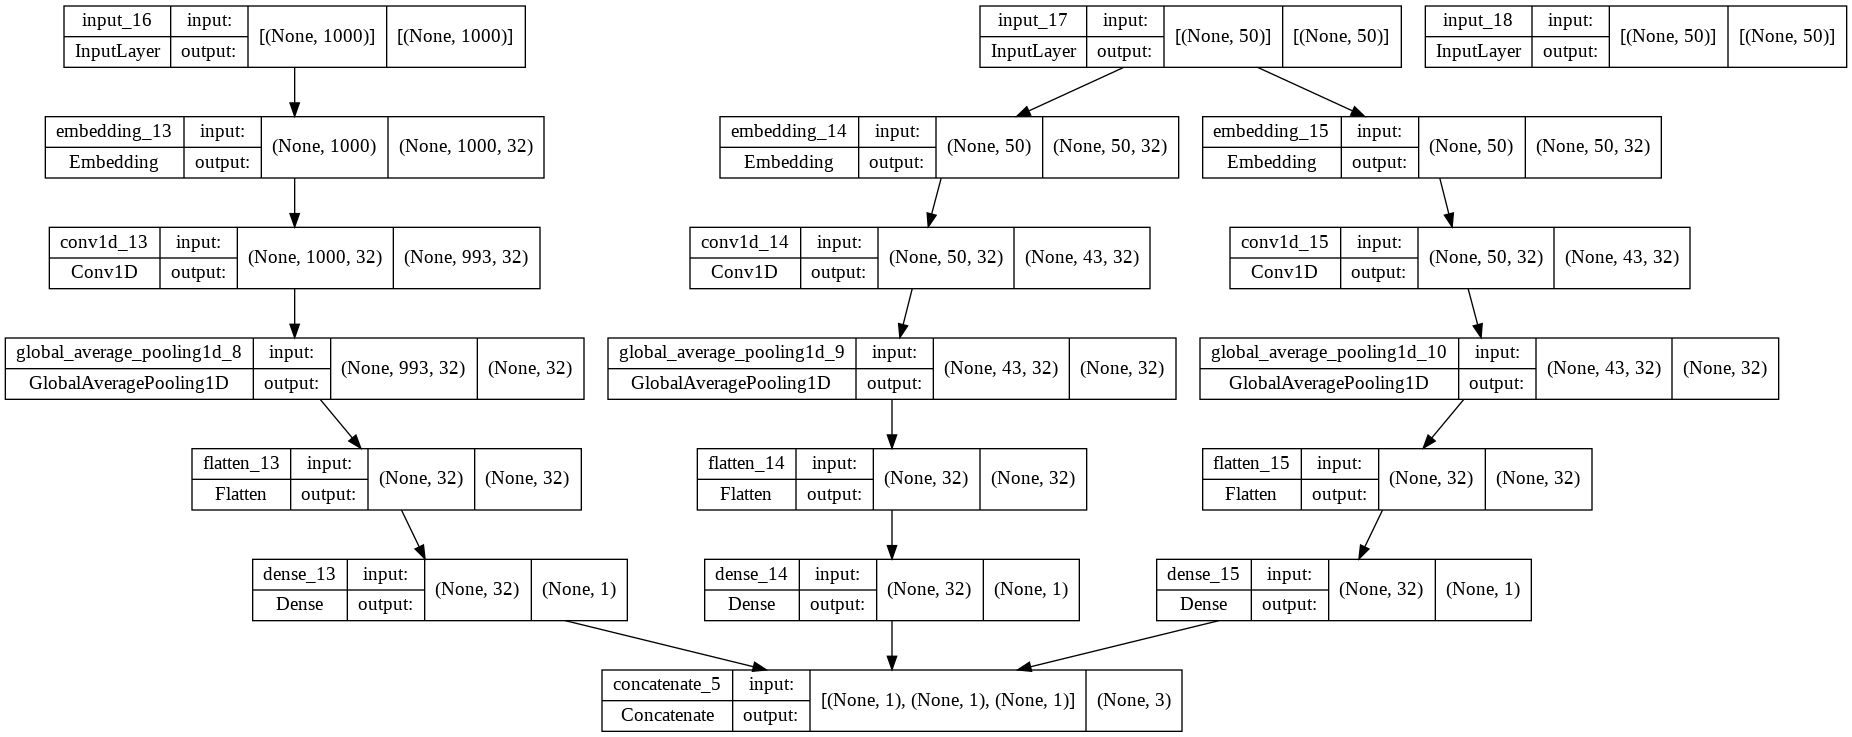

In [ ]:
# plotting the model
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# only using two input
emb_size = 32
num_filters = 32
ker_size = 8

input_summary = Input(shape=(1000, ), dtype="int64")
input_amenities = Input(shape=(50, ), dtype="int64")

# summary
summary_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=emb_size)(input_summary) 
x_summary = layers.Conv1D(filters = num_filters, kernel_size = ker_size, activation = 'relu')(summary_embeddings)
x_summary = layers.GlobalAveragePooling1D()(x_summary)
x_summary= layers.Flatten()(x_summary)
dense_summary = layers.Dense(1)(x_summary)

# amenities
amenities_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=emb_size)(input_amenities) 
x_amenities = layers.Conv1D(filters = num_filters, kernel_size = ker_size, activation = 'relu')(amenities_embeddings)
x_amenities = layers.GlobalAveragePooling1D()(x_amenities)
x_amenities= layers.Flatten()(x_amenities)
dense_amenities = Dense(1)(x_amenities)

# Concatenate
output_layer = concatenate([dense_summary, dense_amenities],axis=-1)
model = Model(inputs=[input_summary, input_amenities], outputs = output_layer)
              
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae','mse'])
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 50)]         0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 1000, 32)     320000      ['input_9[0][0]']                
                                                                                                  
 embedding_7 (Embedding)        (None, 50, 32)       320000      ['input_10[0][0]']               
                                                                                            

In [ ]:
# let's check whether dropping one textual features will affect the performance
callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_mse', patience = 3,restore_best_weights=True)]

model.fit([x_train_summary,x_train_amenities], y_train, 
    epochs = 10,
    batch_size = 64,
    callbacks=callbacks,
    validation_split=0.2)

Epoch 1/10
692/692 [==============================] - 116s 166ms/step - loss: 8868.8467 - mae: 65.7663 - mse: 8868.8467 - val_loss: 6779.8535 - val_mae: 59.6054 - val_mse: 6779.8535
Epoch 2/10
692/692 [==============================] - 100s 145ms/step - loss: 7024.0190 - mae: 59.8460 - mse: 7024.0190 - val_loss: 6712.6323 - val_mae: 59.5552 - val_mse: 6712.6323
Epoch 3/10
692/692 [==============================] - 104s 150ms/step - loss: 6822.8999 - mae: 58.6438 - mse: 6822.8999 - val_loss: 6416.2432 - val_mae: 55.9517 - val_mse: 6416.2432
Epoch 4/10
692/692 [==============================] - 103s 149ms/step - loss: 6600.8545 - mae: 57.2936 - mse: 6600.8545 - val_loss: 6334.4512 - val_mae: 56.4304 - val_mse: 6334.4512
Epoch 5/10
692/692 [==============================] - 99s 143ms/step - loss: 6543.3369 - mae: 57.0356 - mse: 6543.3369 - val_loss: 6310.4326 - val_mae: 55.3881 - val_mse: 6310.4326
Epoch 6/10
692/692 [==============================] - 100s 145ms/step - loss: 6509.7124 - m

Seems like having all three text features will result in better performance even it's just a little.

## 5.5 CNN With MaxPooling



In [ ]:
emb_size = 32
num_filters = 32
ker_size = 8

input_summary = Input(shape=(1000, ), dtype="int64")
input_name = Input(shape=(50, ), dtype="int64")
input_amenities = Input(shape=(50, ), dtype="int64")

# summary
summary_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=emb_size)(input_summary) 
x_summary = layers.Conv1D(filters = num_filters, kernel_size = ker_size, activation = 'relu')(summary_embeddings)
x_summary = layers.MaxPooling1D(2)(x_summary)
x_summary= layers.Flatten()(x_summary)
dense_summary = layers.Dense(1)(x_summary)

# name
name_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=emb_size)(input_name) 
x_name = layers.Conv1D(filters = num_filters, kernel_size = ker_size, activation = 'relu')(name_embeddings)
x_name = layers.MaxPooling1D(2)(x_name)
x_name= layers.Flatten()(x_name)
dense_name = Dense(1)(x_name)

# amenities
amenities_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=emb_size)(input_amenities) 
x_amenities = layers.Conv1D(filters = num_filters, kernel_size = ker_size, activation = 'relu')(amenities_embeddings)
x_amenities = layers.MaxPooling1D(2)(x_amenities)
x_amenities= layers.Flatten()(x_amenities)
dense_amenities = Dense(1)(x_amenities)

# Concatenate
output_layer = concatenate([dense_summary, dense_name, x_amenities],axis=-1)
model = Model(inputs=[input_summary, input_name, input_amenities], outputs = output_layer) 

model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae','mse'])
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 1000)]       0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 50)]         0           []                               
                                                                                                  
 embedding_10 (Embedding)       (None, 1000, 32)     320000      ['input_13[0][0]']               
                                                                                                  
 embedding_11 (Embedding)       (None, 50, 32)       320000      ['input_14[0][0]']               
                                                                                            

In [ ]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_mse', patience = 3,restore_best_weights=True)]

model.fit([x_train_summary,x_train_name, x_train_amenities], y_train, 
    epochs = 10,
    batch_size = 64,
    callbacks=callbacks,
    validation_split=0.2)

Epoch 1/10
692/692 [==============================] - 117s 170ms/step - loss: 11907.4785 - mae: 75.4083 - mse: 11907.4785 - val_loss: 6792.5942 - val_mae: 59.1621 - val_mse: 6792.5942
Epoch 2/10
692/692 [==============================] - 116s 168ms/step - loss: 7062.3022 - mae: 60.0166 - mse: 7062.3022 - val_loss: 6791.7026 - val_mae: 59.1805 - val_mse: 6791.7026
Epoch 3/10
692/692 [==============================] - 112s 162ms/step - loss: 7061.7314 - mae: 59.9455 - mse: 7061.7314 - val_loss: 6790.0894 - val_mae: 59.0237 - val_mse: 6790.0894
Epoch 4/10
692/692 [==============================] - 116s 168ms/step - loss: 7061.1587 - mae: 60.0172 - mse: 7061.1587 - val_loss: 6792.8936 - val_mae: 59.4570 - val_mse: 6792.8936
Epoch 5/10
692/692 [==============================] - 113s 163ms/step - loss: 7060.8315 - mae: 59.9790 - mse: 7060.8315 - val_loss: 6793.5859 - val_mae: 59.5875 - val_mse: 6793.5859
Epoch 6/10
692/692 [==============================] - 115s 167ms/step - loss: 7060.7583 

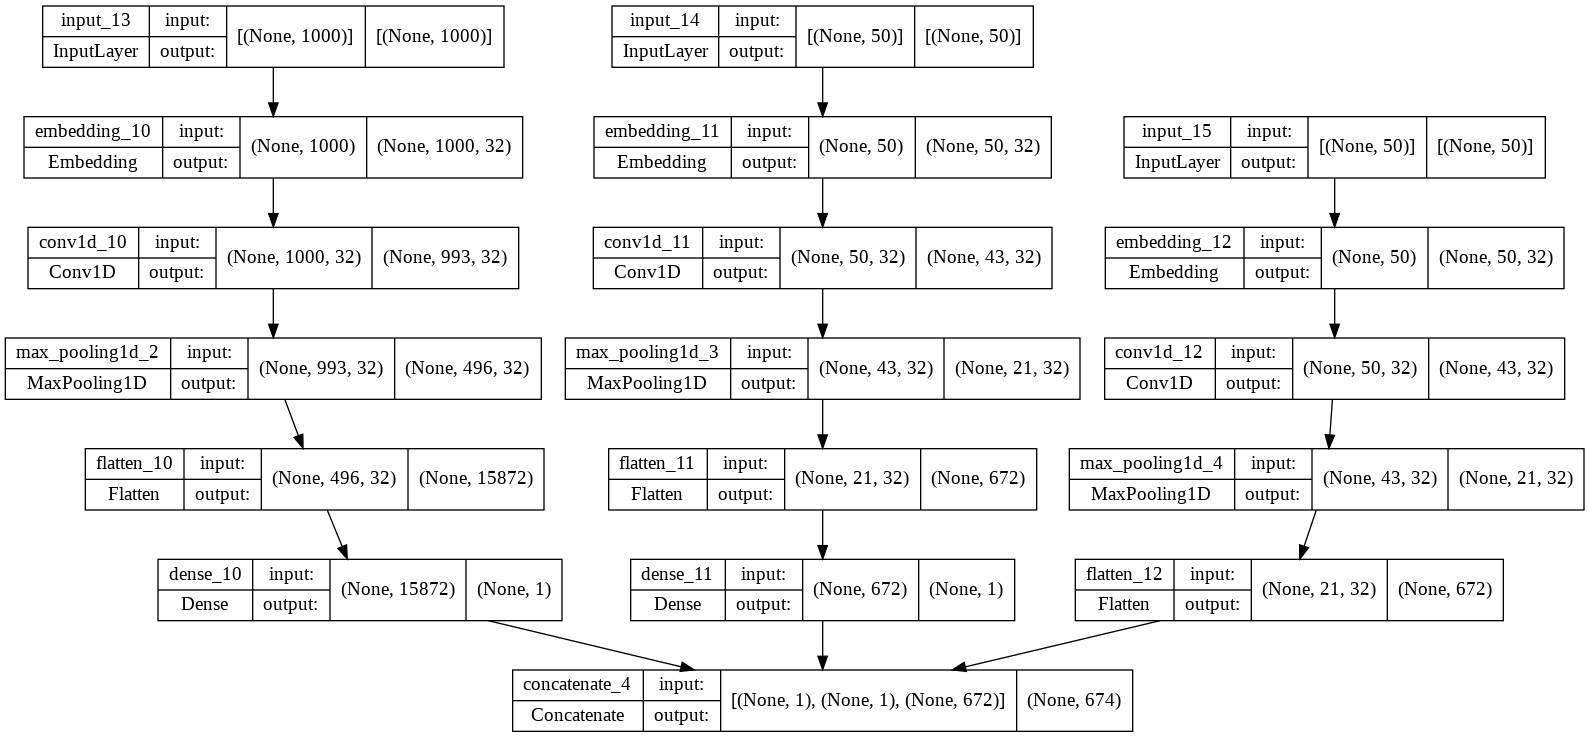

In [ ]:
#This plotting approach should work with any Keras model
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

We can tell that textual data itself is not as informative as other non-textual features. That's an interesting findings. Therefore, we would combine textual and non-textual features together and see the performance. </br>
Even though LSTM is mostly used in sequential text identification, the performance is slightly worst then CNN in our testing, together with long training time. My guess is with lemmatization it may destroy some part of the connection between words and make LSTM performs not as good as CNN. Also, the amenities columns may not provide so many sequential relationship in textual data as it's not a complete sentence. </br>
From the CNN model, seems like Maxpooling is doing a slightly better job then globalaveragepooling. As the CNN + maxpooling performs the best, we are going to apply it in the final model.

# 6. Combine Textual and non-textual features

### 6.1 Only 10 best features

We learned that too many features will create noise in our models, so we would apply the models on 10 best features from random forest + textual data, and also all non-textual features + textual data to compare the results.

In [ ]:
# just a recall, the important_feature is the top 10 variables calcualted from the random forest
important_feature = (pd.Series(rf.feature_importances_, index=X_val.columns).nlargest(10)).index

In [ ]:
emb_size = 16
num_filters = 32
ker_size = 8

input_summary = Input(shape=(1000, ), dtype="int64")
input_name = Input(shape=(50, ), dtype="int64")
input_amenities = Input(shape=(50, ), dtype="int64")
metric_inp= tf.keras.Input(shape = (10, ))

# summary
summary_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=emb_size)(input_summary) 
x_summary = layers.Conv1D(filters = num_filters, kernel_size = ker_size, activation = 'relu')(summary_embeddings)
x_summary = Dropout(0.5)(x_summary)
x_summary = layers.GlobalAveragePooling1D()(x_summary)
x_summary= layers.Flatten()(x_summary)
dense_summary = layers.Dense(1)(x_summary)

# name
name_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=emb_size)(input_name) 
x_name = layers.Conv1D(filters = num_filters, kernel_size = ker_size, activation = 'relu')(name_embeddings)
x_name = Dropout(0.5)(x_name)
x_name = layers.GlobalAveragePooling1D()(x_name)
x_name= layers.Flatten()(x_name)
dense_name = Dense(1)(x_name)

# amenities
amenities_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=emb_size)(input_amenities) 
x_amenities = layers.Conv1D(filters = num_filters, kernel_size = ker_size, activation = 'relu')(amenities_embeddings)
x_amenities = Dropout(0.5)(x_amenities)
x_amenities = layers.GlobalAveragePooling1D()(x_amenities)
x_amenities= layers.Flatten()(x_amenities)
dense_amenities = Dense(1)(x_amenities)

# Concatenate
concate = concatenate([dense_summary, dense_name, dense_amenities, metric_inp],axis=-1)
x = Dense(1024, activation="relu")(concate)
x = Dense(512, activation="relu")(x)
x = Dense(256, activation="relu")(x)
outputs = Dense(1, activation="linear")(x)

model = tf.keras.Model([input_summary,input_name, input_amenities, metric_inp], [outputs])

model.compile(loss="mean_squared_error", optimizer='rmsprop', metrics=['mae','mse'])
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None, 1000)]       0           []                               
                                                                                                  
 input_37 (InputLayer)          [(None, 50)]         0           []                               
                                                                                                  
 input_38 (InputLayer)          [(None, 50)]         0           []                               
                                                                                                  
 embedding_24 (Embedding)       (None, 1000, 16)     160000      ['input_36[0][0]']               
                                                                                            

In [ ]:
x_train_first10 = x_train_nosplt[important_feature]

# use only the most important 15 features for the non_textual data
callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_mse', patience = 3,restore_best_weights=True)]

model.fit([x_train_summary,x_train_name, x_train_amenities, x_train_first10], y_train, 
    epochs = 50,
    batch_size = 64,
    callbacks=callbacks,
    validation_split=0.2)

Epoch 1/50
692/692 [==============================] - 101s 142ms/step - loss: 4046.3989 - mae: 39.7054 - mse: 4046.3989 - val_loss: 3511.7505 - val_mae: 40.3174 - val_mse: 3511.7505
Epoch 2/50
692/692 [==============================] - 99s 143ms/step - loss: 3241.2754 - mae: 35.2184 - mse: 3241.2754 - val_loss: 3119.2891 - val_mae: 32.5047 - val_mse: 3119.2891
Epoch 3/50
692/692 [==============================] - 99s 143ms/step - loss: 2907.7244 - mae: 33.1508 - mse: 2907.7244 - val_loss: 2719.6492 - val_mae: 32.0341 - val_mse: 2719.6492
Epoch 4/50
692/692 [==============================] - 99s 143ms/step - loss: 2768.1819 - mae: 32.0779 - mse: 2768.1819 - val_loss: 2895.6370 - val_mae: 31.2435 - val_mse: 2895.6370
Epoch 5/50
692/692 [==============================] - 98s 142ms/step - loss: 2671.4844 - mae: 31.4916 - mse: 2671.4844 - val_loss: 3597.0564 - val_mae: 35.3004 - val_mse: 3597.0564
Epoch 6/50
692/692 [==============================] - 100s 144ms/step - loss: 2638.9807 - mae:

In [ ]:
x_test_15 = x_test_nosplt[important_feature]
final_composite_predictions = pd.DataFrame(model.predict([x_test_summary, x_test_name,x_test_amenities,x_test_15]), columns=["price"], index=x_test_nosplt.index)
final_composite_predictions

,price
0,118.718208
1,148.637283
2,127.697426
3,109.008018
4,156.625198
...,...
29764,396.677399
29765,96.393913
29766,347.468872
29767,94.283195


### 6.2 All non-textual features

In [ ]:
emb_size = 16
num_filters = 32
ker_size = 8

input_summary = Input(shape=(1000, ), dtype="int64")
input_name = Input(shape=(50, ), dtype="int64")
input_amenities = Input(shape=(50, ), dtype="int64")
metric_inp= tf.keras.Input(shape = (x_train_nosplt.shape[1], ))

# summary
summary_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=emb_size)(input_summary) 
x_summary = layers.Conv1D(filters = num_filters, kernel_size = ker_size, activation = 'relu')(summary_embeddings)
x_summary = SpatialDropout1D(0.5)(x_summary)
x_summary = layers.GlobalAveragePooling1D()(x_summary)
x_summary= layers.Flatten()(x_summary)
dense_summary = layers.Dense(1)(x_summary)

# name
name_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=emb_size)(input_name) 
x_name = layers.Conv1D(filters = num_filters, kernel_size = ker_size, activation = 'relu')(name_embeddings)
x_name = SpatialDropout1D(0.5)(x_name)
x_name = layers.GlobalAveragePooling1D()(x_name)
x_name= layers.Flatten()(x_name)
dense_name = Dense(1)(x_name)

# amenities
amenities_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=emb_size)(input_amenities) 
x_amenities = layers.Conv1D(filters = num_filters, kernel_size = ker_size, activation = 'relu')(amenities_embeddings)
x_amenities = SpatialDropout1D(0.5)(x_amenities)
x_amenities = layers.GlobalAveragePooling1D()(x_amenities)
x_amenities= layers.Flatten()(x_amenities)
dense_amenities = Dense(1)(x_amenities)

# Concatenate
concate = concatenate([dense_summary, dense_name, dense_amenities, metric_inp],axis=-1)
x = Dense(1024, activation="relu")(concate)
x = Dense(512, activation="relu")(x)
x = Dense(256, activation="relu")(x)
outputs = Dense(1, activation="linear")(x)

model = tf.keras.Model([input_summary,input_name, input_amenities, metric_inp], [outputs])

model.compile(loss="mean_squared_error", optimizer='rmsprop', metrics=['mae','mse'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 1000)]       0           []                               
                                                                                                  
 input_21 (InputLayer)          [(None, 50)]         0           []                               
                                                                                                  
 input_22 (InputLayer)          [(None, 50)]         0           []                               
                                                                                                  
 embedding_12 (Embedding)       (None, 1000, 16)     160000      ['input_20[0][0]']               
                                                                                            

In [ ]:
# use all features for the non_textual data
callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_mse', patience = 3,restore_best_weights=True)]

model.fit([x_train_summary,x_train_name, x_train_amenities, x_train_nosplt], y_train, 
    epochs = 20,
    batch_size = 64,
    callbacks=callbacks,
    validation_split=0.2)

Epoch 1/20
692/692 [==============================] - 171s 244ms/step - loss: 3935.3000 - mae: 39.5367 - mse: 3935.3000 - val_loss: 3299.4446 - val_mae: 40.4456 - val_mse: 3299.4446
Epoch 2/20
692/692 [==============================] - 171s 247ms/step - loss: 3046.4771 - mae: 34.1963 - mse: 3046.4771 - val_loss: 2854.3208 - val_mae: 33.6407 - val_mse: 2854.3208
Epoch 3/20
692/692 [==============================] - 157s 226ms/step - loss: 2786.0710 - mae: 32.5068 - mse: 2786.0710 - val_loss: 2665.2070 - val_mae: 33.7253 - val_mse: 2665.2070
Epoch 4/20
692/692 [==============================] - 166s 240ms/step - loss: 2660.0952 - mae: 31.5899 - mse: 2660.0952 - val_loss: 2961.7144 - val_mae: 31.6838 - val_mse: 2961.7144
Epoch 5/20
692/692 [==============================] - 160s 231ms/step - loss: 2565.8767 - mae: 30.9416 - mse: 2565.8767 - val_loss: 3424.4692 - val_mae: 33.5576 - val_mse: 3424.4692
Epoch 6/20
692/692 [==============================] - 156s 226ms/step - loss: 2508.2493 - 

In [ ]:
# save and load model if needed
# model.save('CNN_all_features')
# model = keras.models.load_model('CNN_all_features')


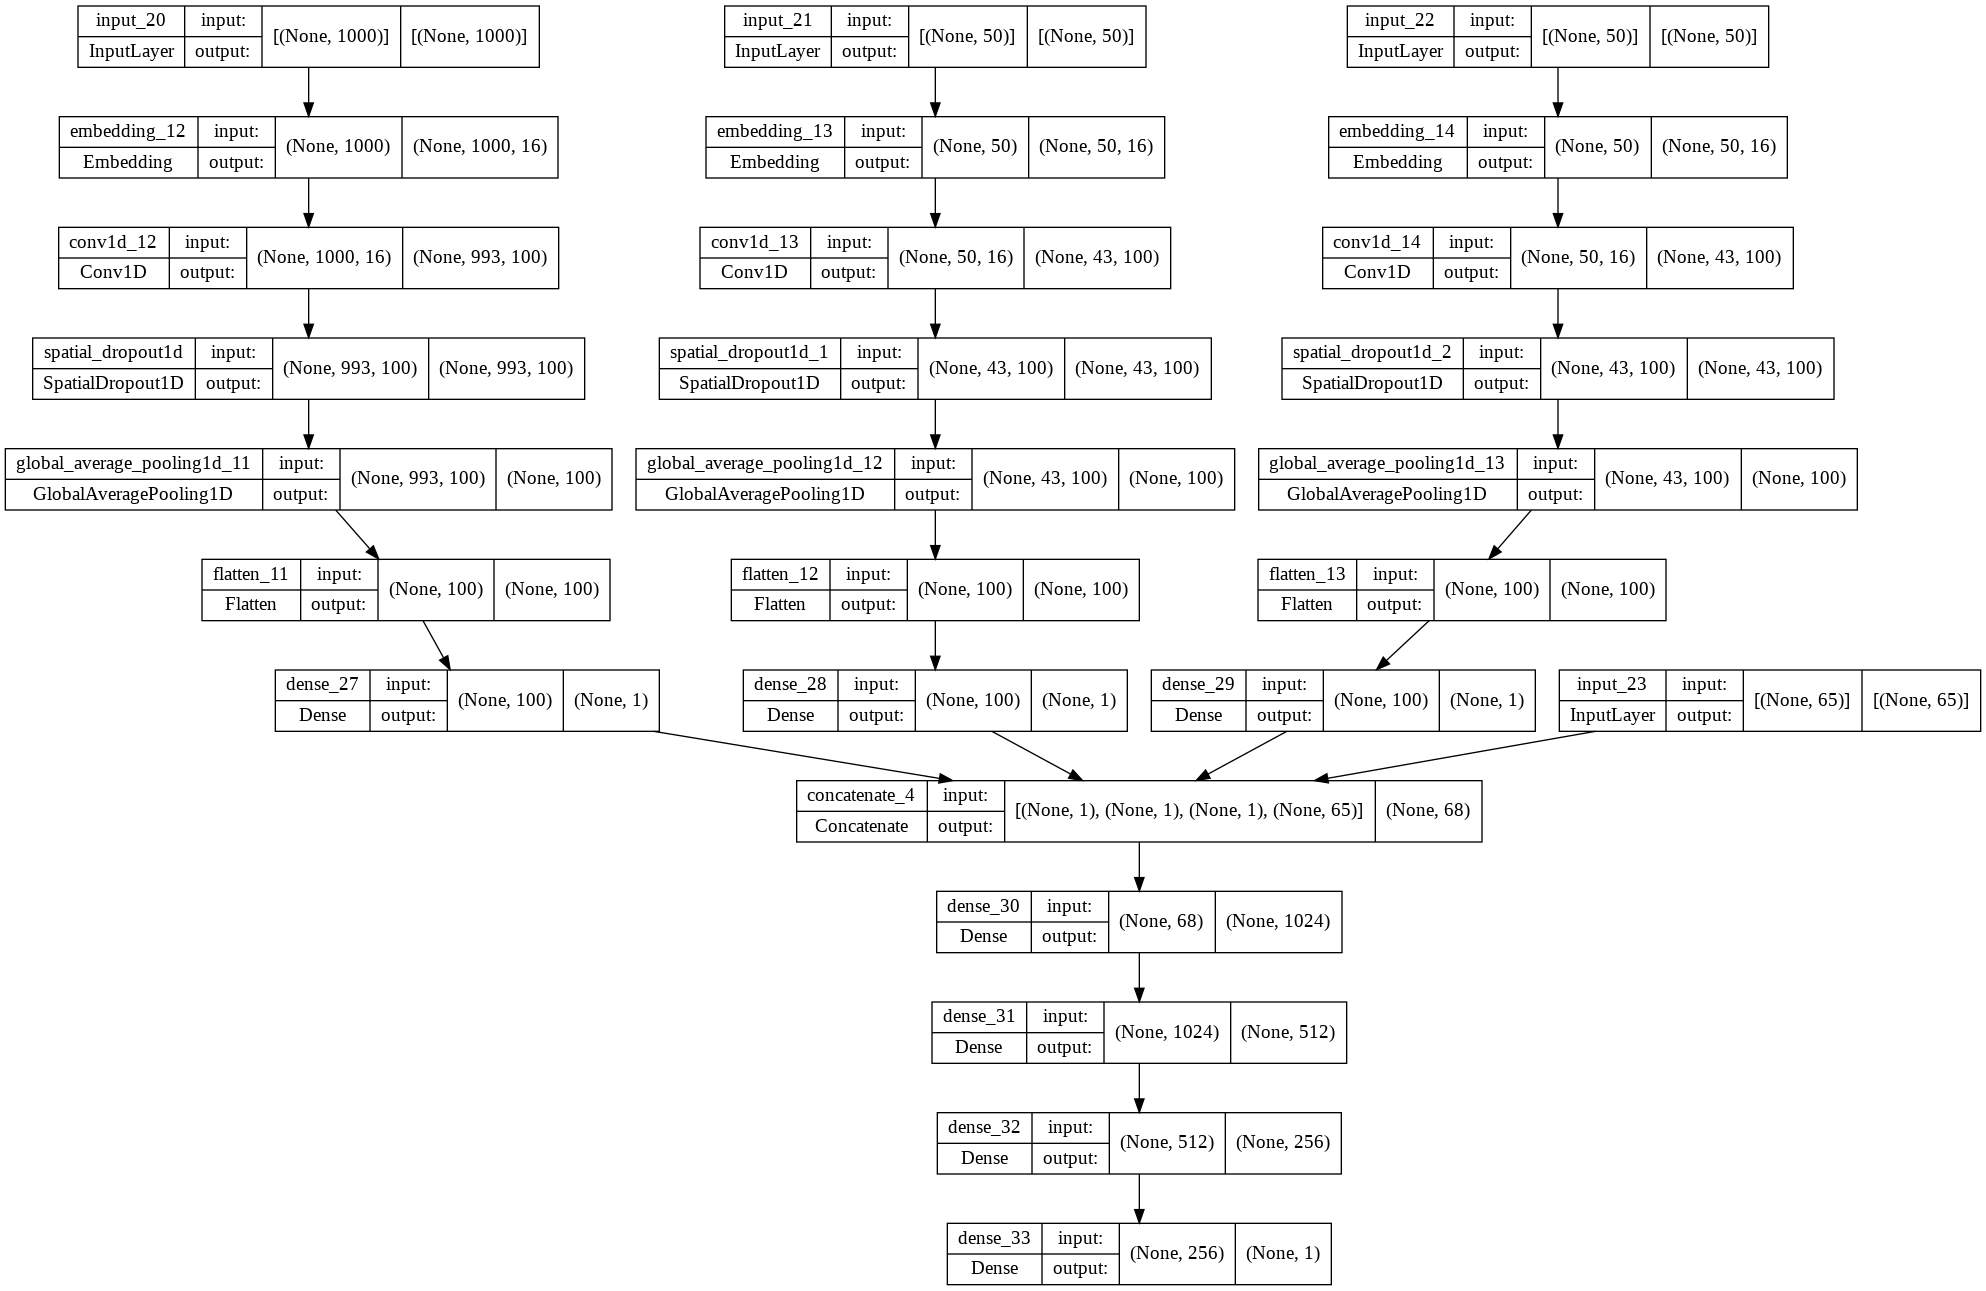

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

### 6.3 Export the result

In [ ]:
final_composite_predictions = pd.DataFrame(model.predict([x_test_summary, x_test_name,x_test_amenities,x_test_nosplt]), columns=["price"], index=x_test_nosplt.index)
final_composite_predictions

,price
0,176.723541
1,270.567474
2,199.600800
3,229.577209
4,272.330994
...,...
29764,382.805481
29765,130.841949
29766,335.375610
29767,111.570816


In [ ]:
# concat the predicated price with test data
pred = pd.concat([df_notext_test,final_composite_predictions], axis=1)
pred.head()

,listing_id,experiences_offered,host_response_time,host_response_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,room_type,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month,summary_clean,name_clean,amenities_clean,price
0,0FEMC4VA5U,none,Missing,nan,True,True,True,Kensington and Chelsea,Apartment,Entire home/apt,...,1.0,1.0,1.0,1.0,flexible,0.123441,large bright contemporary flat locate heart la...,ladbroke grove stylish portobello apartment,cable internet wifi kitchen heating wifi kitch...,118.718208
1,PQ2BYEO0QR,none,within an hour,100,True,True,True,Westminster,Apartment,Entire home/apt,...,1.0,1.0,1.0,1.0,flexible,0.163493,stylish design beautiful tree line street nott...,contemporary design notting hill,cable internet wifi kitchen heating wifi kitch...,148.637283
2,3FP6WFHUBN,none,Missing,nan,True,True,True,Camden,House,Private room,...,1.0,1.0,1.0,1.0,flexible,0.065003,quiet ensuite double bedroom lovely house camd...,,cable internet wifi kitchen heating wifi kitch...,127.697426
3,GG0V2KDG90,none,Missing,nan,True,True,True,Tower Hamlets,Apartment,Private room,...,1.0,1.0,1.0,1.0,flexible,0.065003,place close aldgate love place view location a...,double room balcony magnificent penthouse,cable internet wifi kitchen heating wifi kitch...,109.008018
4,TZVVK4YSIO,none,a few days or more,0,True,True,True,Kensington and Chelsea,Boutique hotel,Private room,...,1.0,1.0,1.0,1.0,moderate,0.061720,suite comprise bedroom bathroom excellent bala...,bockery suite chelsea,cable internet wifi kitchen heating wifi kitch...,156.625198


In [ ]:
output = pred[['listing_id', 'price']]

In [ ]:
from google.colab import files

output.to_csv('prediction_yeungwingshan.csv', index=False)
files.download('prediction_yeungwingshan.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Even though the validation score for 10 best features and all features are the same, the results on Kaggle actually suggested that 10 best features would have a better performance and lower RMSE. I believe this is because the model would overfit the data with all features.
